In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 1000, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')     

In [6]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [7]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','Coef_a','Coef_b', 'ZPE', 'Coef_d'], axis=1, inplace = True)

In [8]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [9]:
d=data.copy()
d.columns.values

array(['Coef_c', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [10]:
columns = list(d.columns.values)

# Standard Scaling

In [11]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data['Coef_c']).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data['Coef_c']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['Coef_c'] 
X = data_std.drop(['Coef_c'], axis=1)

In [12]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [13]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_BP', 'A_Hf', 'B_Hv', 'A_MV', 'X_ChiA', 'A_Ra', 'B_M', 'X_MendeleevNo', 'X_Ra', 'X_B', 'A_BP', 'A_M', 'B_BP', 'A_MendeleevNo', 'X_IEII', 'X_M', 'X_Hv', 'X_Rc', 'X_Hf', 'A_Rc', 'A_Hv', 'X_CvM', 'X_MP'}


In [14]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape

(80, 51)

### Test-train splitting 

In [15]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =100)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_c')
X = df_train

Y_test = df_test.pop('Coef_c')
X_test = df_test

RF 0.9472097297038226
RMSE:  0.24018716825380013
RMSE unscaled:  0.009026455878127723
----------------------------------------


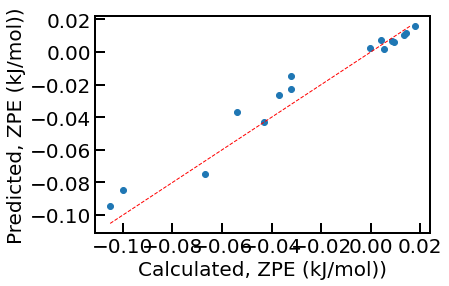

GB 0.9514394825150115
RMSE:  0.23036394762611337
RMSE unscaled:  0.008657290163649446
----------------------------------------


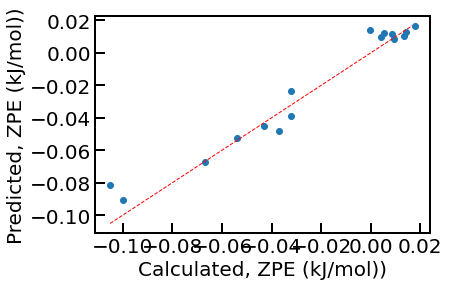

LR 0.9465983901831969
RMSE:  0.24157391283520524
RMSE unscaled:  0.009078571021785437
----------------------------------------


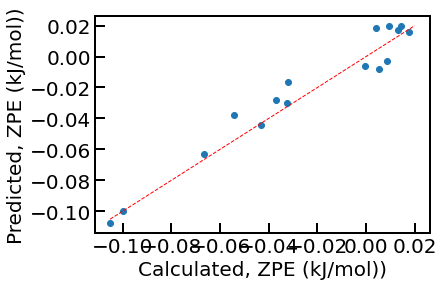

RR 0.9743211884181221
RMSE:  0.16751755261424545
RMSE unscaled:  0.00629546452659218
----------------------------------------


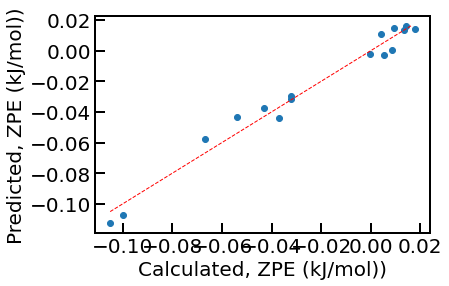

LASSO 0.9704746702055843
RMSE:  0.1796264296810318
RMSE unscaled:  0.006750527323541951
----------------------------------------


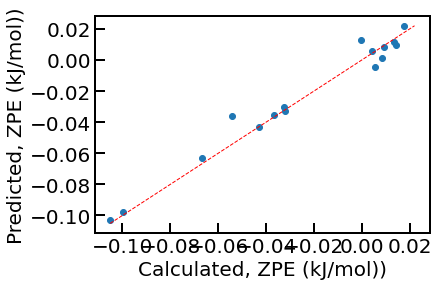

gpr1 0.9786392879170707
RMSE:  0.15278500131548176
RMSE unscaled:  0.005741801625957856
----------------------------------------


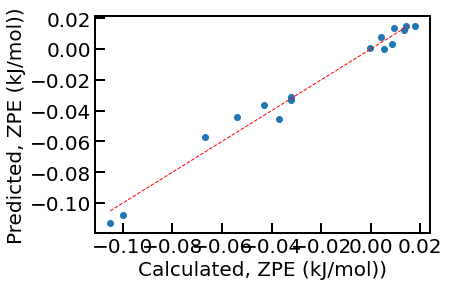

gpr2 0.975322600092428
RMSE:  0.16421868065667586
RMSE unscaled:  0.006171489868041186
----------------------------------------


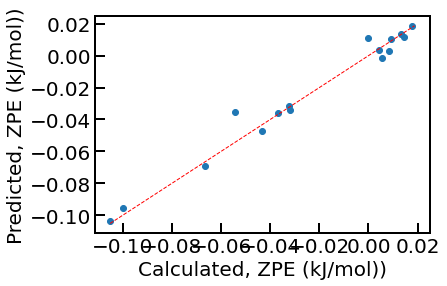

gpr3 0.9478961939530721
RMSE:  0.23862040769892423
RMSE unscaled:  0.008967575567730647
----------------------------------------


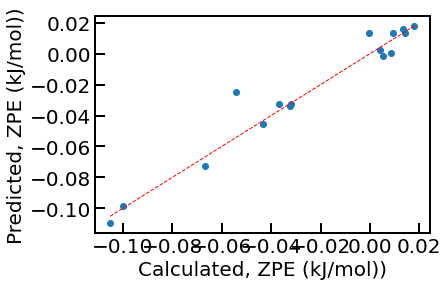

gpr4 0.9478961938643982
RMSE:  0.2386204079019747
RMSE unscaled:  0.008967575575361474
----------------------------------------


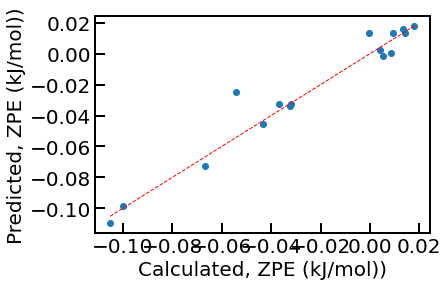

gpr5 0.9508863272103655
RMSE:  0.23167227604244267
RMSE unscaled:  0.008706458355314115
----------------------------------------


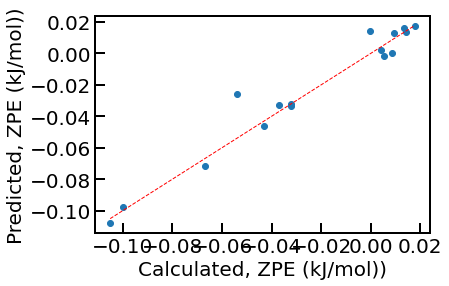

gpr6 0.9288080102806366
RMSE:  0.27892563126455616
RMSE unscaled:  0.010482283138573141
----------------------------------------


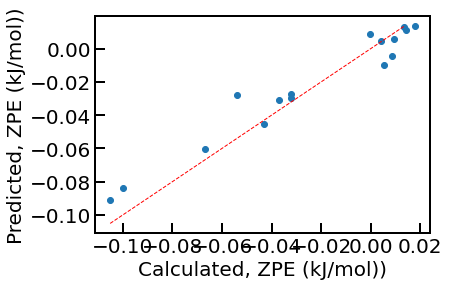

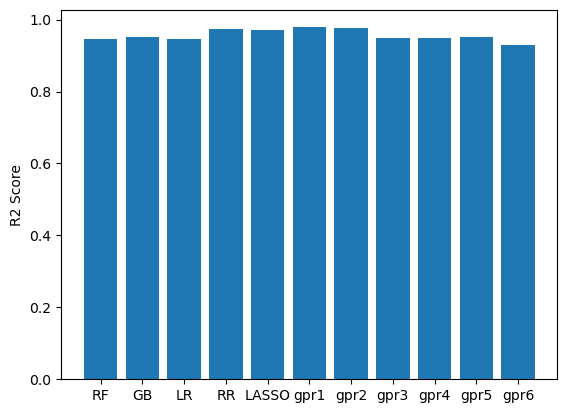

In [16]:
run_models()

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  231.128739
14       X_Z  176.926471
4   mean_X2X   92.210958
2   mean_A2X   66.148330
32    X_Rvdw   52.648989
44   X_Kappa   35.631509
30    A_Rvdw   33.021651
25      X_EA   26.641739
9      E_coh   25.403869
18     A_IEI   19.549273
20     X_IEI   18.603283
40      X_MV   18.091216
6    std_A2X   11.326145
43   B_Kappa   11.216382
24      B_EA   11.007417
29    A_ChiA   10.579056
12       A_Z   10.172426
7    std_B2X   10.018863
28    X_ChiP    8.718756
26    A_ChiP    8.410498
42   A_Kappa    7.269082
35      A_MP    6.684227
45     A_CvM    6.495909
41      B_Hf    5.729254
13       B_Z    5.436054
36      B_MP    5.239934
39      B_MV    4.904610
23      A_EA    4.098901
47       A_B    3.883831
27    B_ChiP    3.720368


In [18]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI', 'X_IEI', 'X_MV', 'std_A2X',
       'B_Kappa', 'B_EA', 'A_ChiA', 'A_Z', 'std_B2X', 'X_ChiP', 'A_ChiP',
       'A_Kappa', 'A_MP', 'A_CvM', 'B_Hf', 'B_Z', 'B_MP', 'B_MV', 'A_EA',
       'A_B', 'B_ChiP'], dtype=object)

In [19]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9492041183267306
RMSE:  0.23560641471388674
RMSE unscaled:  0.00885430692438797
----------------------------------------


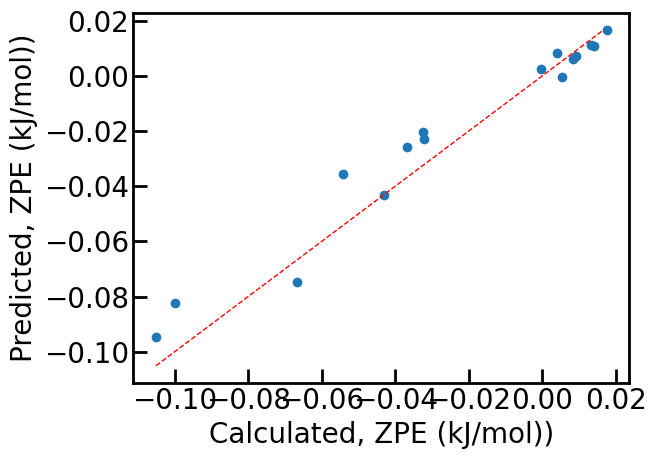

GB 0.9136001874130456
RMSE:  0.30727643769543433
RMSE unscaled:  0.011547732659536935
----------------------------------------


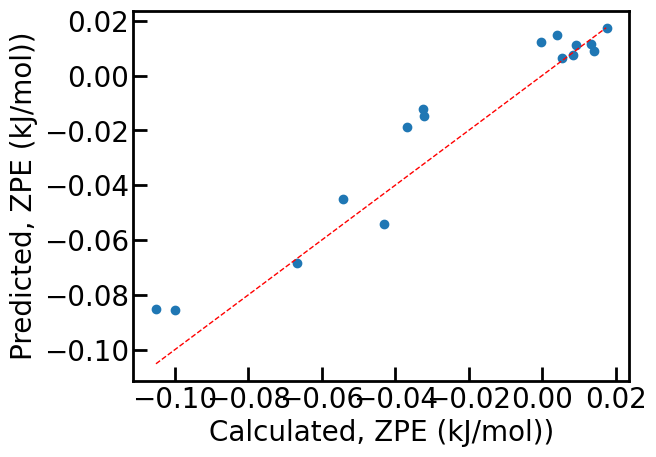

LR 0.9796209783531742
RMSE:  0.14923288139192517
RMSE unscaled:  0.005608309674672924
----------------------------------------


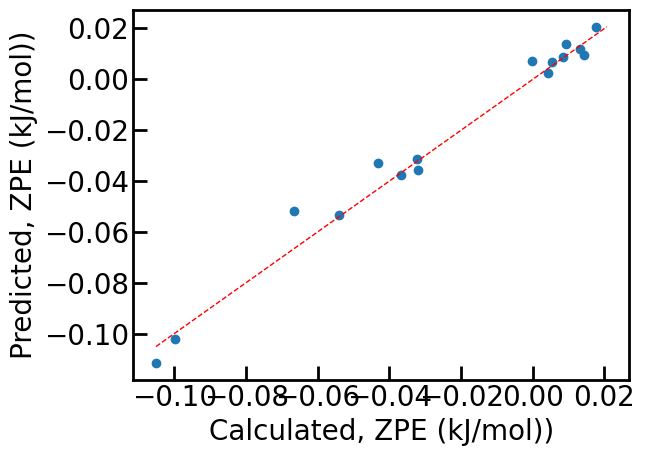

RR 0.9804521287846116
RMSE:  0.14615800071597584
RMSE unscaled:  0.005492752815604433
----------------------------------------


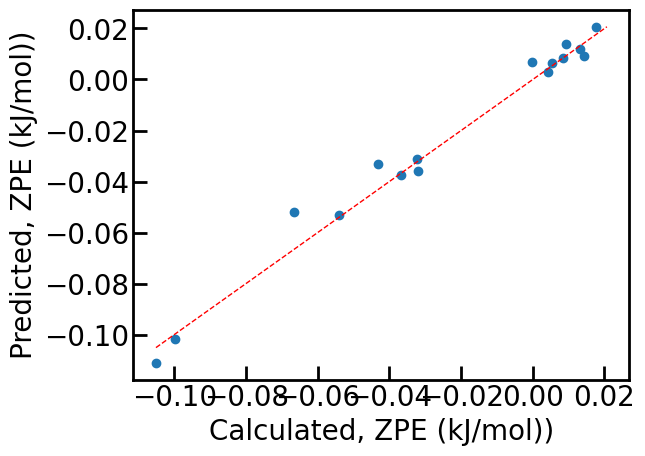

LASSO 0.9675063639613888
RMSE:  0.1884395311164551
RMSE unscaled:  0.007081731824742667
----------------------------------------


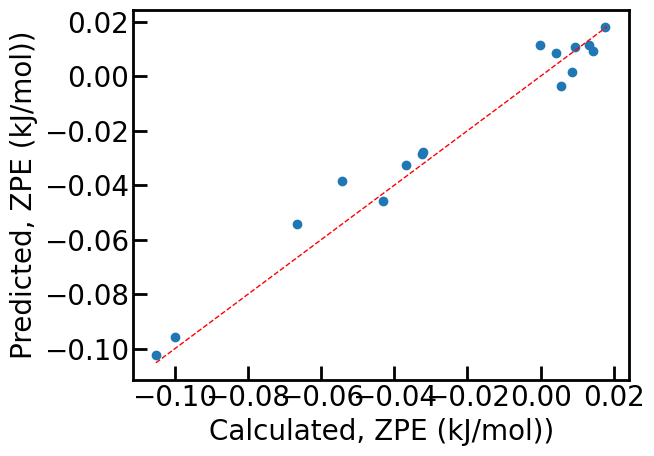

gpr1 0.9823051989607986
RMSE:  0.13905791103619786
RMSE unscaled:  0.005225924880160582
----------------------------------------


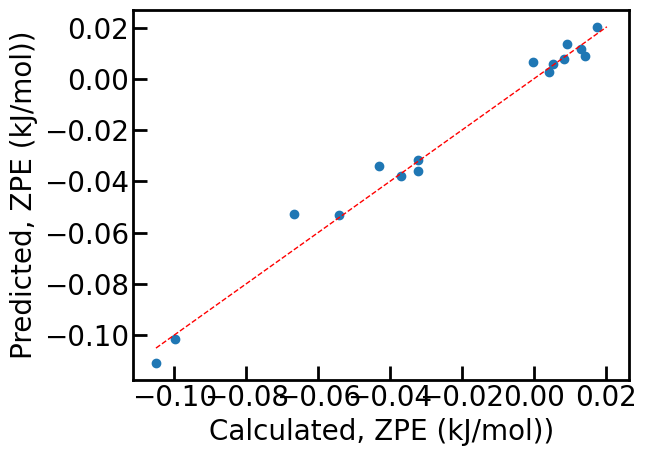

gpr2 0.9880378640073186
RMSE:  0.11433448156036653
RMSE unscaled:  0.004296795539313446
----------------------------------------


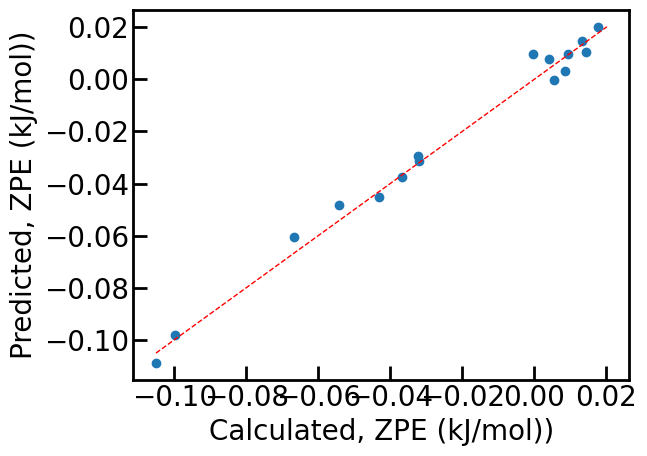

gpr3 0.9887865836788488
RMSE:  0.11069852454559717
RMSE unscaled:  0.0041601529126186485
----------------------------------------


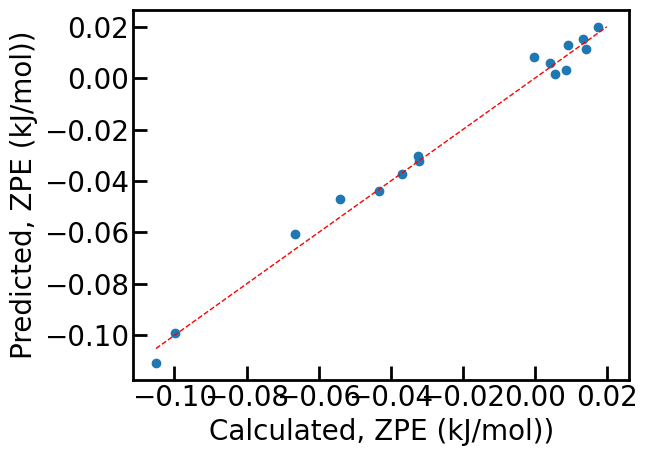

gpr4 0.9887865769649664
RMSE:  0.11069855768521908
RMSE unscaled:  0.004160154158036284
----------------------------------------


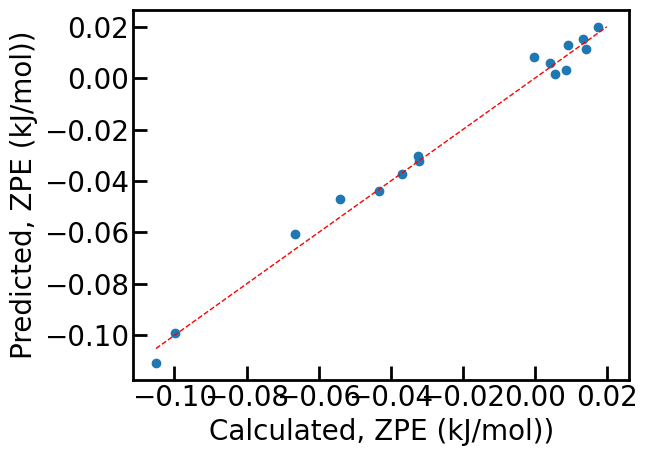

gpr5 0.9888132615216915
RMSE:  0.1105667646814677
RMSE unscaled:  0.0041552012550895665
----------------------------------------


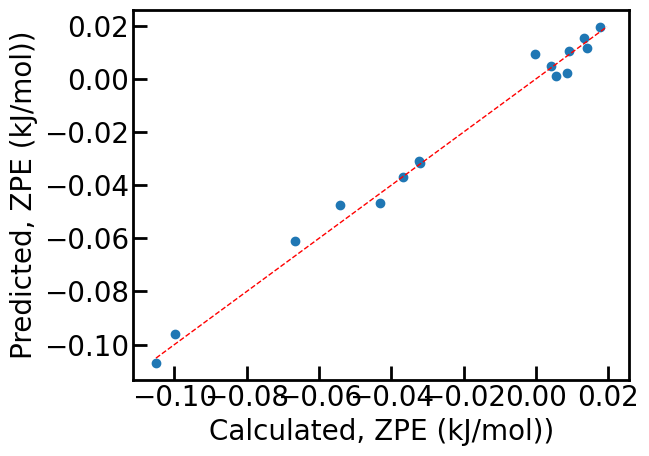

gpr6 0.9378112255784524
RMSE:  0.26069269284531843
RMSE unscaled:  0.009797072453229774
----------------------------------------


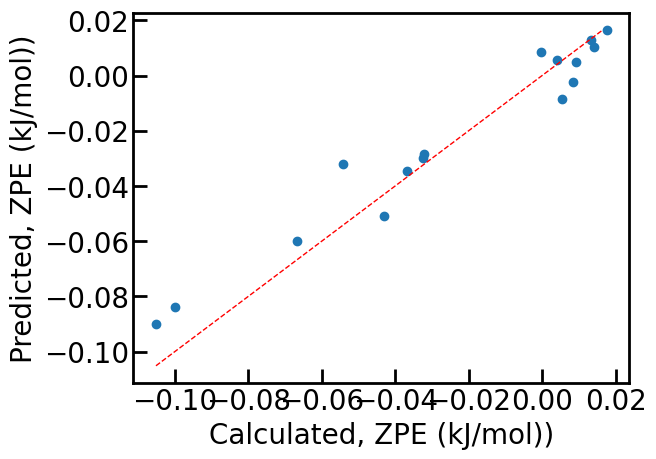

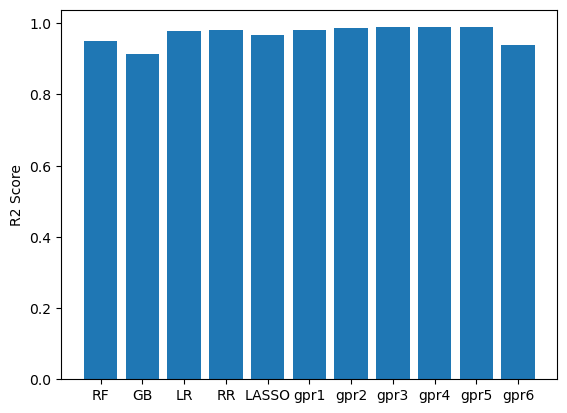

In [20]:
run_models()

In [21]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI', 'X_IEI', 'X_MV', 'std_A2X',
       'B_Kappa', 'B_EA', 'A_ChiA', 'A_Z', 'std_B2X', 'X_ChiP', 'A_ChiP'],
      dtype=object)

In [22]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9438022218271324
RMSE:  0.24781776277385745
RMSE unscaled:  0.009313220676014011
----------------------------------------


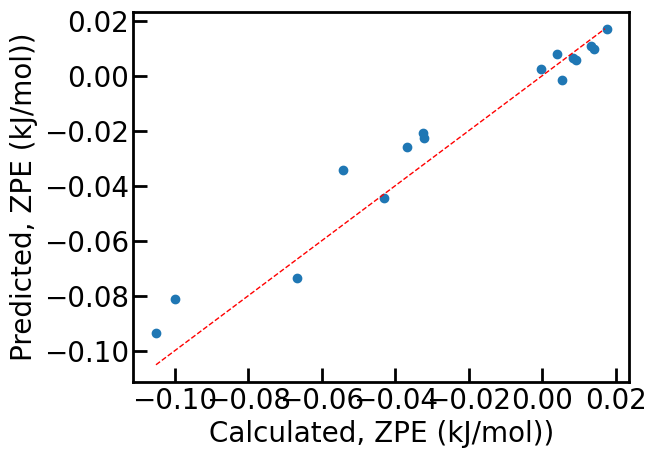

GB 0.959434461664179
RMSE:  0.2105481748239985
RMSE unscaled:  0.007912595098589645
----------------------------------------


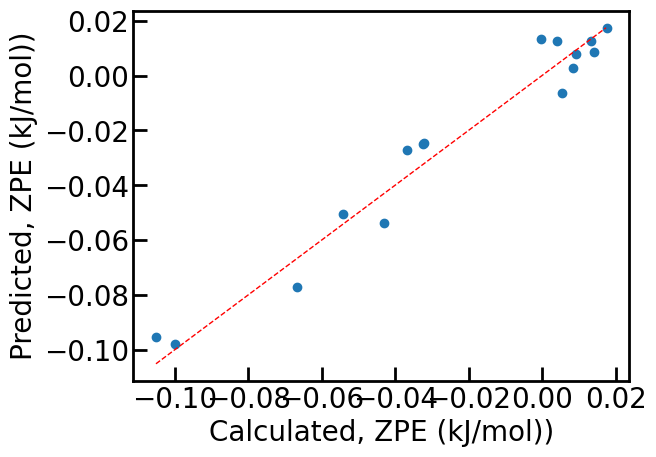

LR 0.9527526314361675
RMSE:  0.22722790893321407
RMSE unscaled:  0.008539434929752666
----------------------------------------


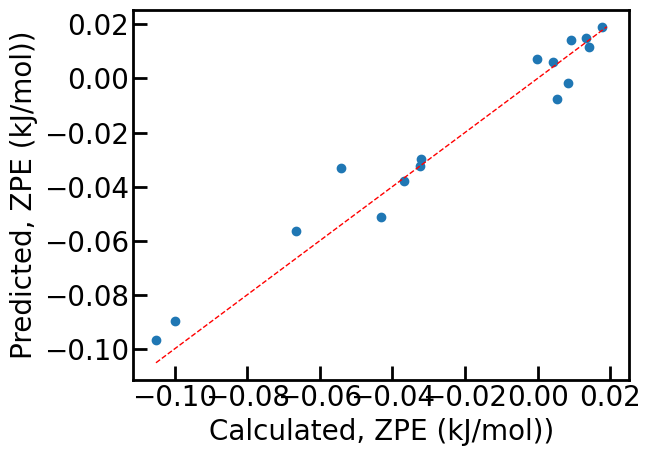

RR 0.9529800284728248
RMSE:  0.22668043637965477
RMSE unscaled:  0.00851886040495554
----------------------------------------


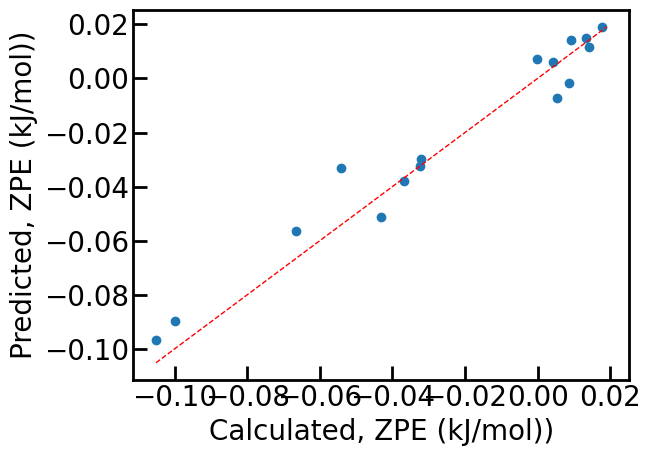

LASSO 0.9496443475789299
RMSE:  0.23458323587477758
RMSE unscaled:  0.008815854917506014
----------------------------------------


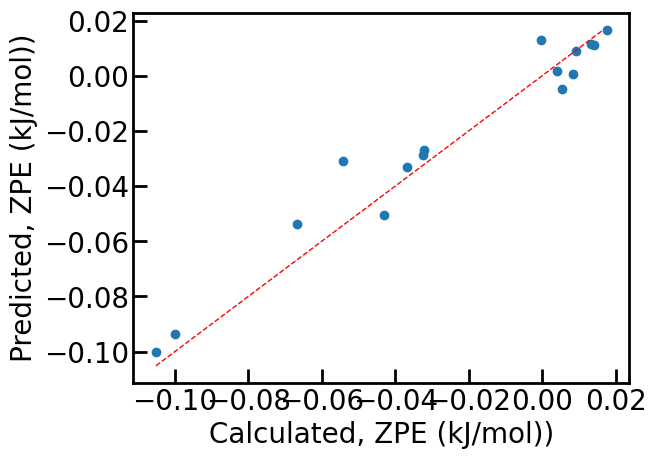

gpr1 0.9549670181595684
RMSE:  0.22183915963811912
RMSE unscaled:  0.008336920748399444
----------------------------------------


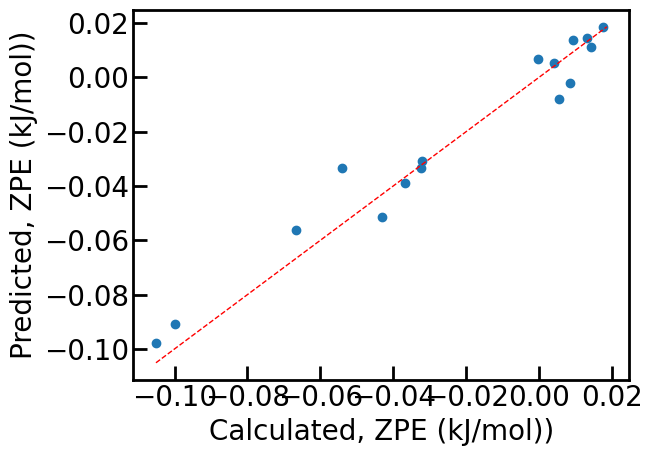

gpr2 0.9753215433657477
RMSE:  0.16422219667546592
RMSE unscaled:  0.006171622003278493
----------------------------------------


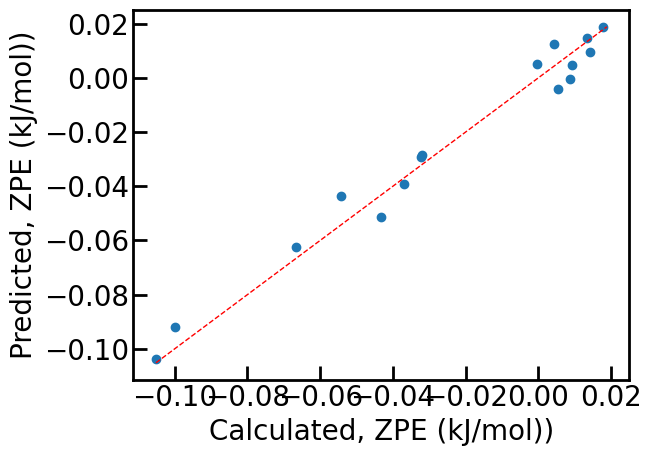

gpr3 0.9663158632572262
RMSE:  0.19186049914104533
RMSE unscaled:  0.007210294966391518
----------------------------------------


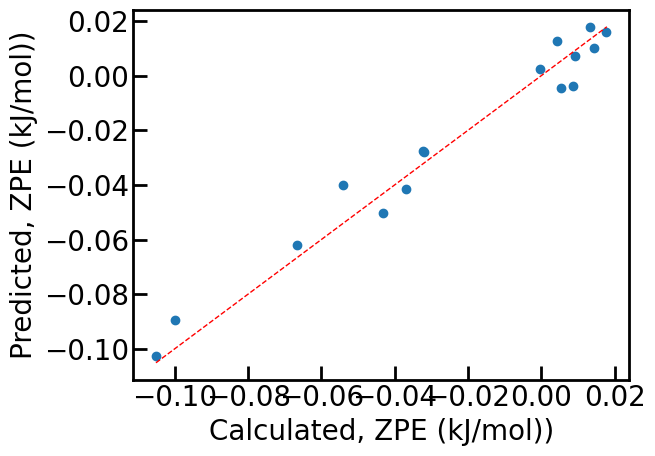

gpr4 0.9663158693456998
RMSE:  0.19186048180146423
RMSE unscaled:  0.007210294314754026
----------------------------------------


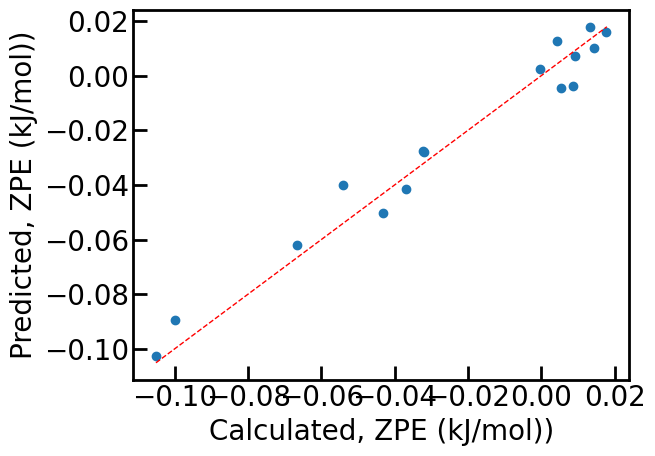

gpr5 0.959048138559312
RMSE:  0.21154836965152826
RMSE unscaled:  0.007950183345063698
----------------------------------------


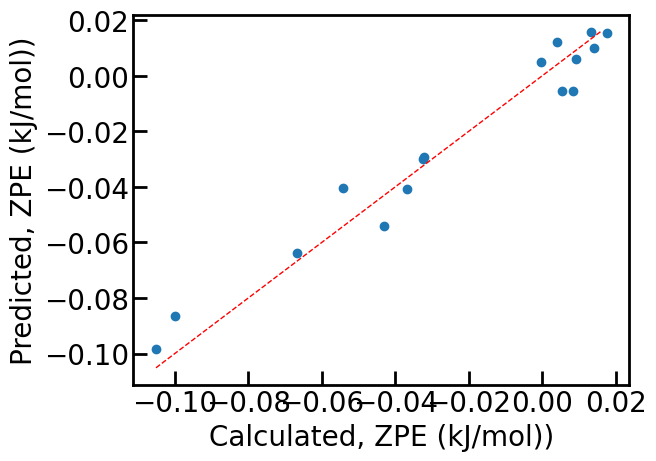

gpr6 0.9189631901096209
RMSE:  0.2975870493003569
RMSE unscaled:  0.011183596484111479
----------------------------------------


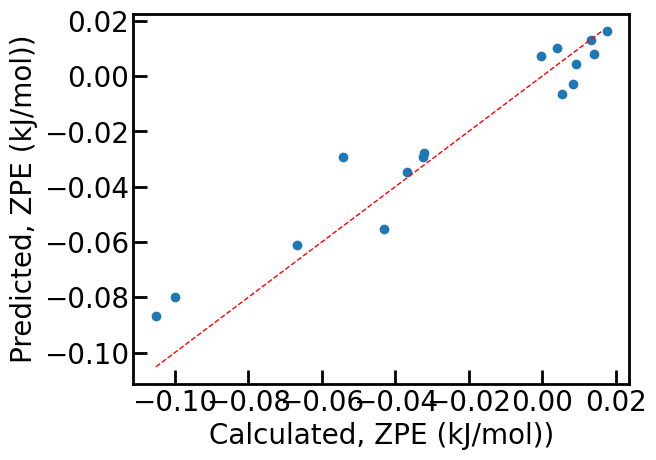

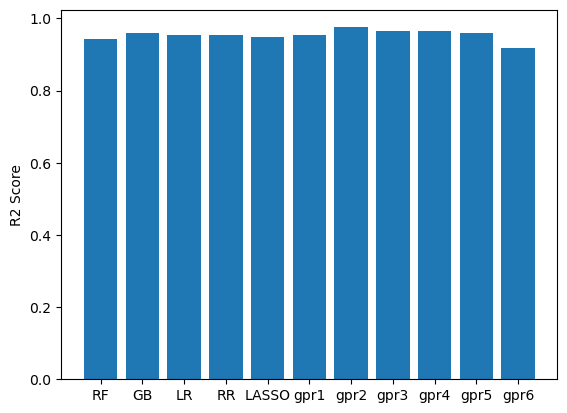

In [23]:
run_models()

In [24]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI'], dtype=object)

In [25]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9122633024755572
RMSE:  0.3096445929605555
RMSE unscaled:  0.01163673012417495
----------------------------------------


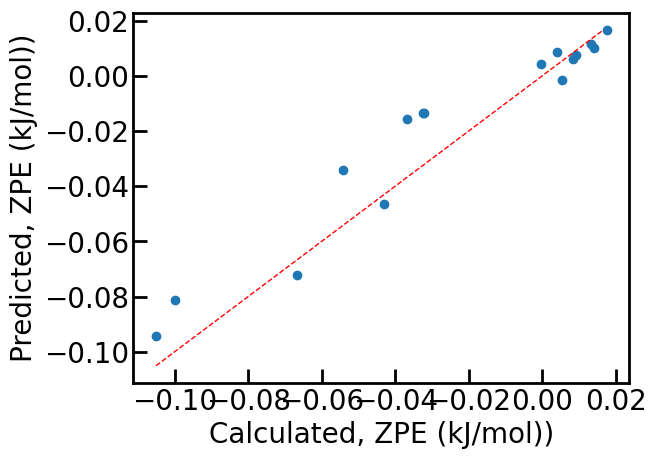

GB 0.8704521737417186
RMSE:  0.3762598900091002
RMSE unscaled:  0.014140194584781274
----------------------------------------


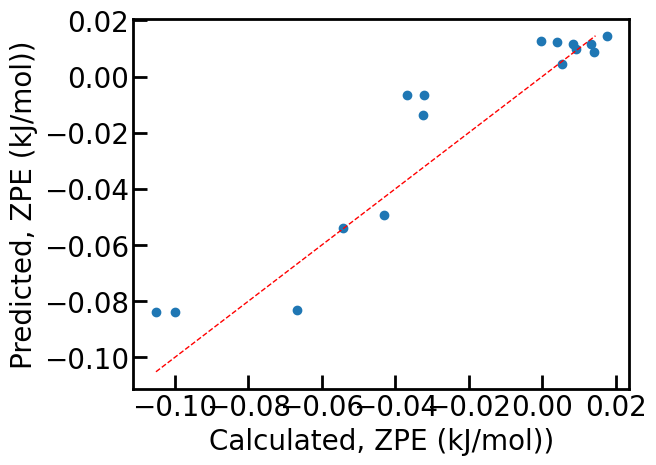

LR 0.8786264578861996
RMSE:  0.3641957490365686
RMSE unscaled:  0.01368681301161996
----------------------------------------


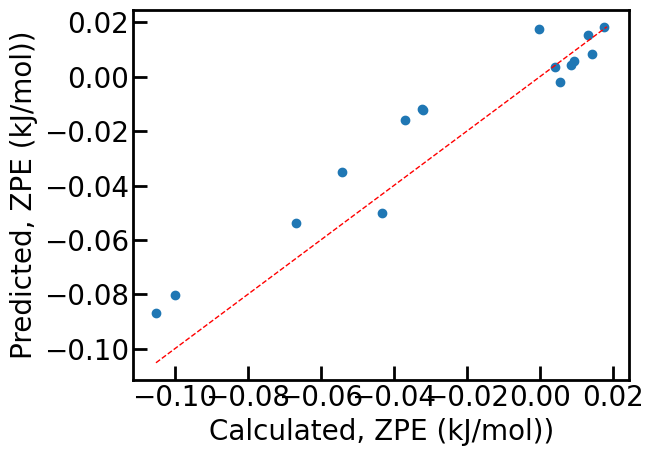

RR 0.8786387141475358
RMSE:  0.36417736038739973
RMSE unscaled:  0.013686121949180662
----------------------------------------


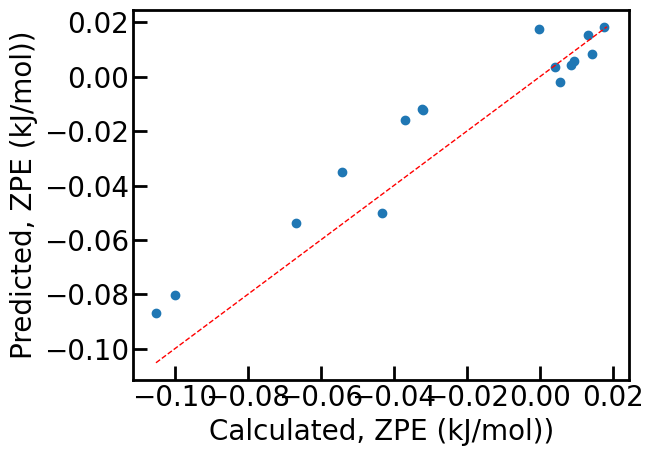

LASSO 0.875407003931435
RMSE:  0.3689943138610768
RMSE unscaled:  0.013867147514839506
----------------------------------------


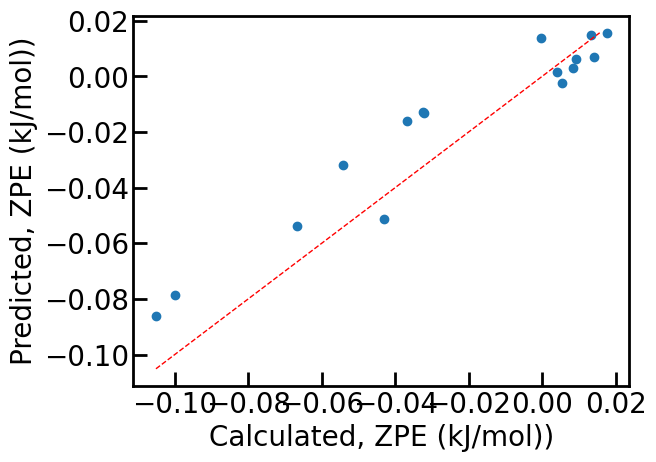

gpr1 0.8958347682589121
RMSE:  0.33739158874324354
RMSE unscaled:  0.012679487882650943
----------------------------------------


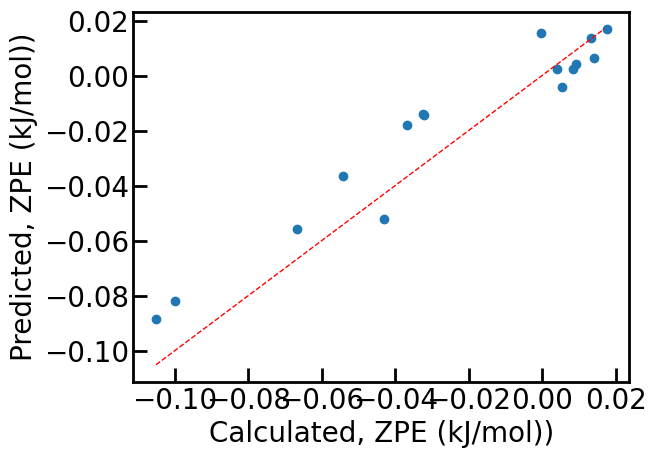

gpr2 0.8924905845779338
RMSE:  0.34276471583913803
RMSE unscaled:  0.01288141496731275
----------------------------------------


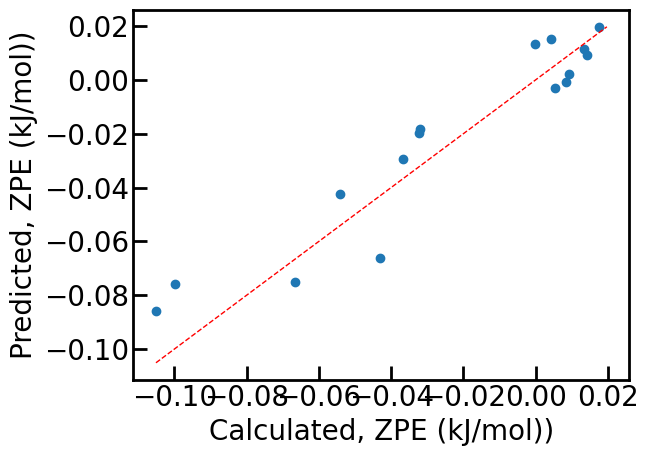

gpr3 0.8492215155849333
RMSE:  0.4059219590998237
RMSE unscaled:  0.015254922568994298
----------------------------------------


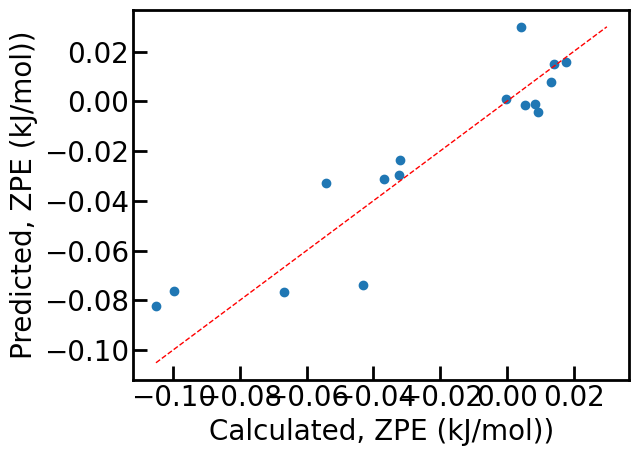

gpr4 0.8492215267899358
RMSE:  0.40592194401691367
RMSE unscaled:  0.015254922002164589
----------------------------------------


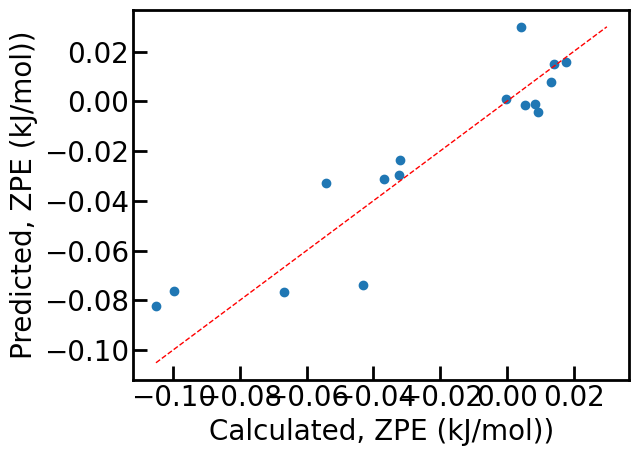

gpr5 0.8460997126822365
RMSE:  0.41010264888051057
RMSE unscaled:  0.015412036756733223
----------------------------------------


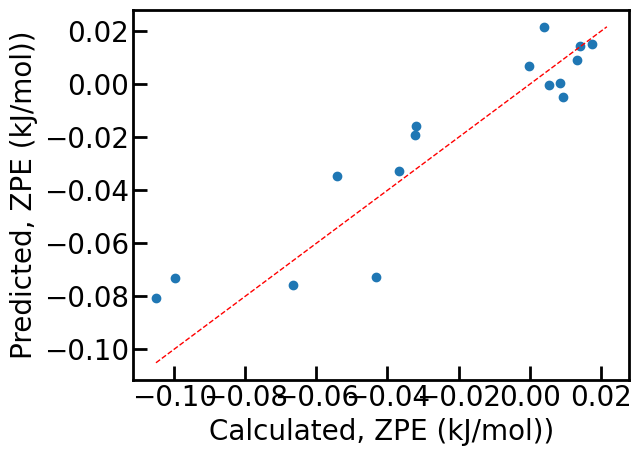

gpr6 0.8734683287624228
RMSE:  0.37185402032707715
RMSE unscaled:  0.013974617928131832
----------------------------------------


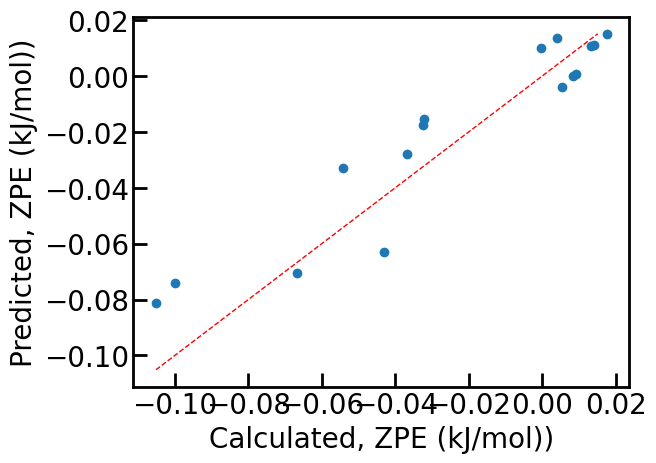

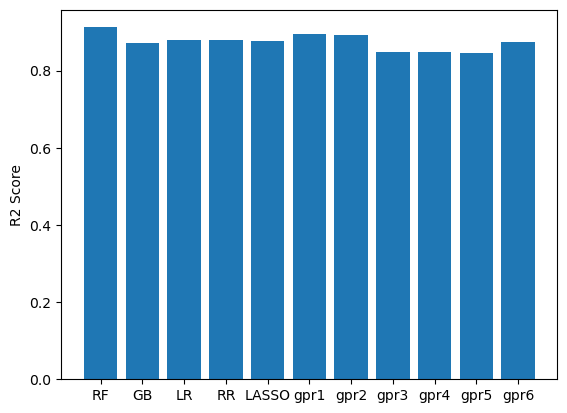

In [26]:
run_models()

# Min-Max scaling

In [27]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data['Coef_c']).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data['Coef_c']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['Coef_c'] 
X = data_std.drop(['Coef_c'], axis=1)

In [28]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [29]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_BP', 'A_Hf', 'B_Hv', 'A_MV', 'X_ChiA', 'A_Ra', 'B_M', 'X_MendeleevNo', 'X_Ra', 'X_B', 'A_BP', 'A_M', 'B_BP', 'A_MendeleevNo', 'X_IEII', 'X_M', 'X_Hv', 'X_Rc', 'X_Hf', 'A_Rc', 'A_Hv', 'X_CvM', 'X_MP'}


In [30]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
#data_std.to_csv('scaled_non_corr_all.csv',index=False)

(80, 51)

In [31]:
print(correlated_features)

{'X_BP', 'A_Hf', 'B_Hv', 'A_MV', 'X_ChiA', 'A_Ra', 'B_M', 'X_MendeleevNo', 'X_Ra', 'X_B', 'A_BP', 'A_M', 'B_BP', 'A_MendeleevNo', 'X_IEII', 'X_M', 'X_Hv', 'X_Rc', 'X_Hf', 'A_Rc', 'A_Hv', 'X_CvM', 'X_MP'}


### Test-train splitting 

In [32]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_c')
X = df_train

Y_test = df_test.pop('Coef_c')
X_test = df_test

RF 0.951368774829177
RMSE:  0.05587094609329839
RMSE unscaled:  0.008663590696651692
----------------------------------------


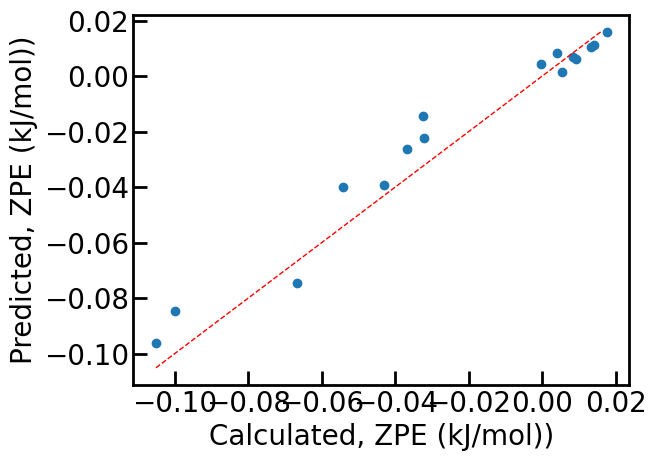

GB 0.9229547534365903
RMSE:  0.0703236404455518
RMSE unscaled:  0.01090468803054402
----------------------------------------


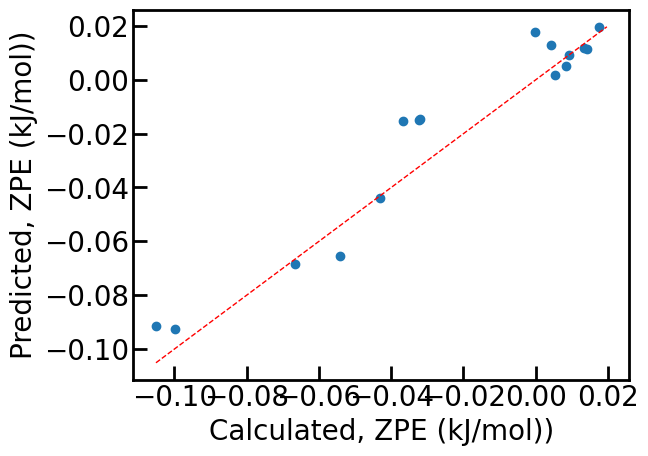

LR 0.9465983901831976
RMSE:  0.058547127850625005
RMSE unscaled:  0.009078571021785383
----------------------------------------


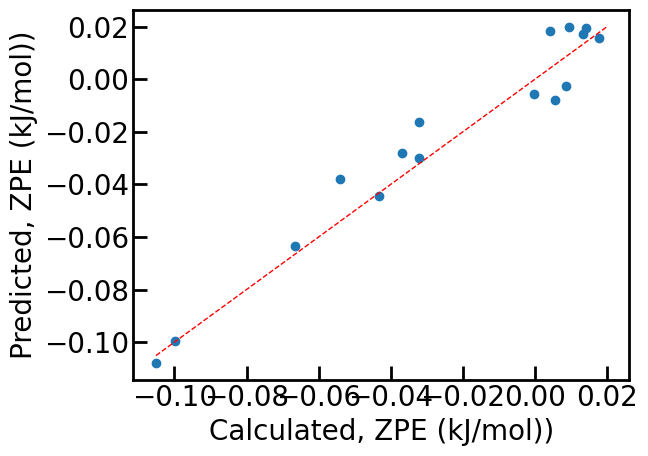

RR 0.9884988806614945
RMSE:  0.027170552834149653
RMSE unscaled:  0.004213183509793067
----------------------------------------


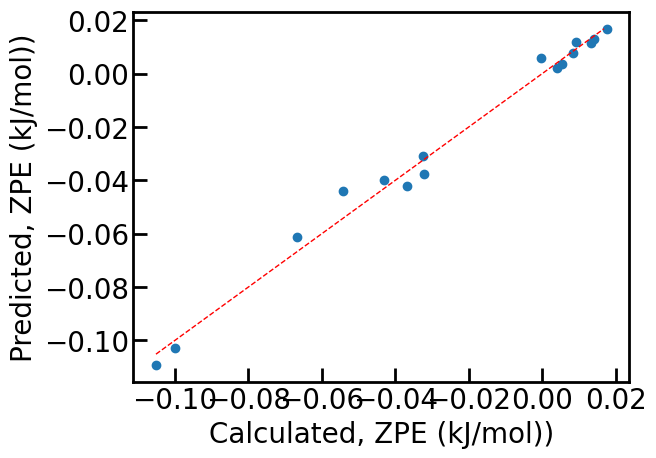

LASSO 0.8242664303315432
RMSE:  0.10620764658259589
RMSE unscaled:  0.016469017319121742
----------------------------------------


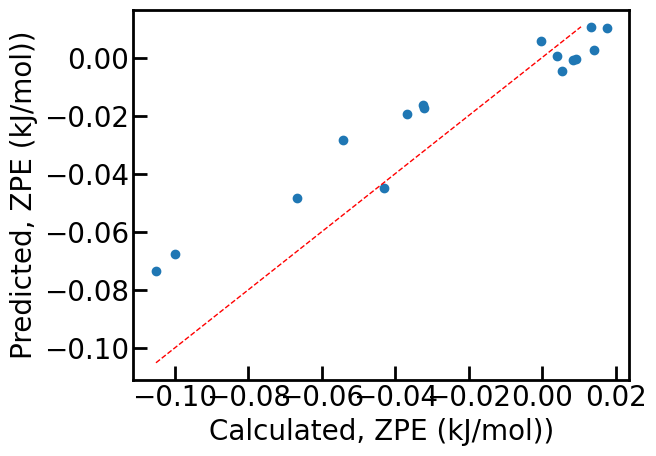

gpr1 0.9713602352032754
RMSE:  0.04287588956219018
RMSE unscaled:  0.0066485209915965945
----------------------------------------


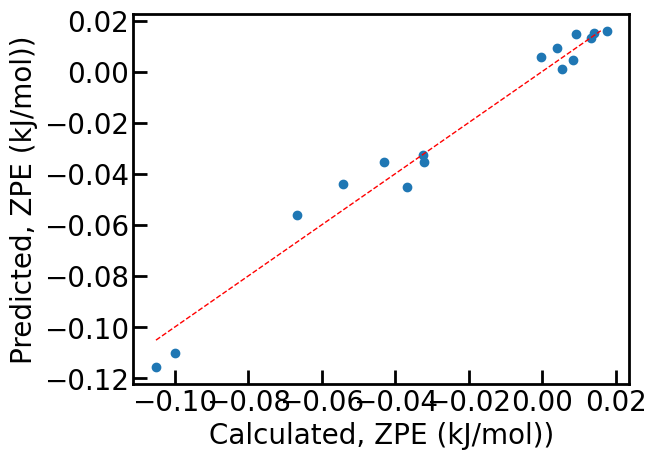

gpr2 0.975999378350368
RMSE:  0.03925000039493186
RMSE unscaled:  0.00608627492538371
----------------------------------------


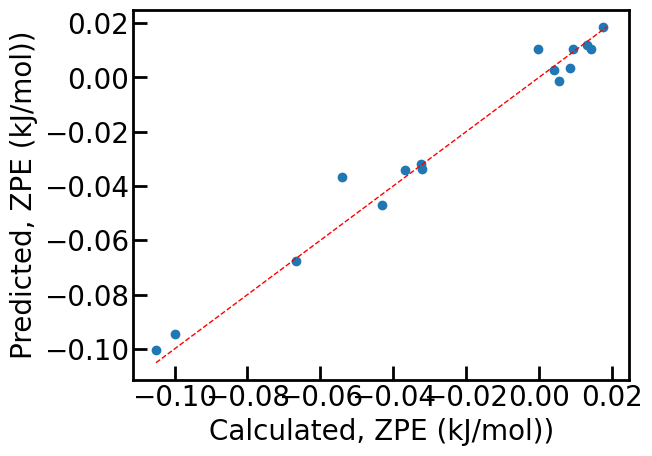

gpr3 0.9465876088972347
RMSE:  0.05855303761134218
RMSE unscaled:  0.009079487414858147
----------------------------------------


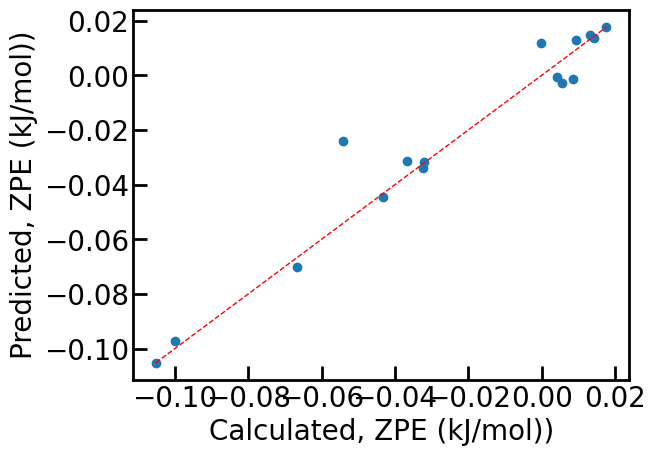

gpr4 0.9465876115746139
RMSE:  0.05855303614381115
RMSE unscaled:  0.009079487187296434
----------------------------------------


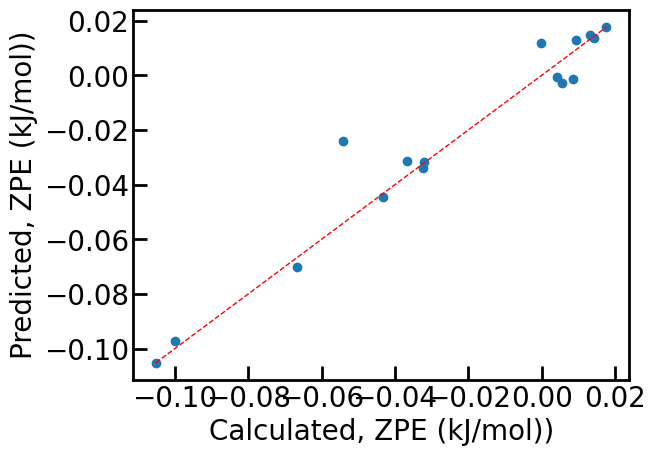

gpr5 0.9429204937444324
RMSE:  0.06052970035368571
RMSE unscaled:  0.00938599729418592
----------------------------------------


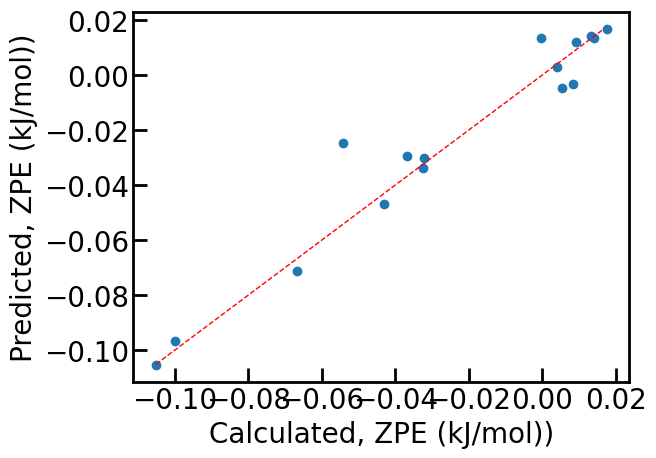

gpr6 0.9416007297233404
RMSE:  0.061225470372580595
RMSE unscaled:  0.009493886404433688
----------------------------------------


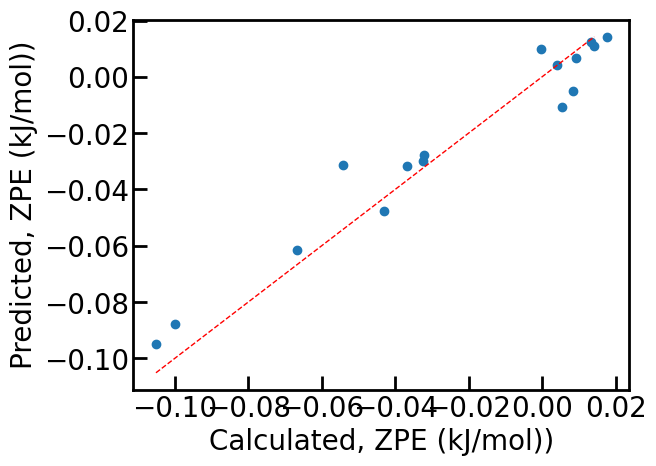

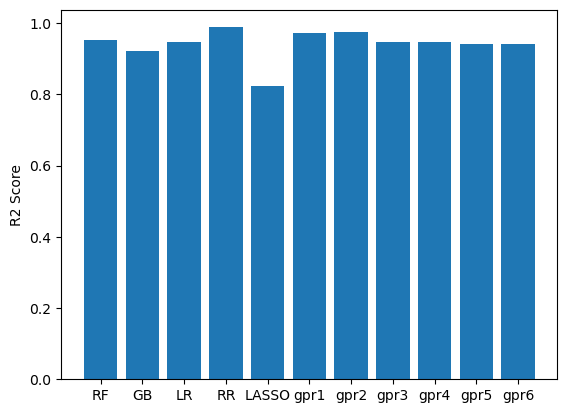

In [33]:
run_models()

## Feature selection


In [34]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  231.128739
14       X_Z  176.926471
4   mean_X2X   92.210958
2   mean_A2X   66.148330
32    X_Rvdw   52.648989
44   X_Kappa   35.631509
30    A_Rvdw   33.021651
25      X_EA   26.641739
9      E_coh   25.403869
18     A_IEI   19.549273
20     X_IEI   18.603283
40      X_MV   18.091216
6    std_A2X   11.326145
43   B_Kappa   11.216382
24      B_EA   11.007417
29    A_ChiA   10.579056
12       A_Z   10.172426
7    std_B2X   10.018863
28    X_ChiP    8.718756
26    A_ChiP    8.410498
42   A_Kappa    7.269082
35      A_MP    6.684227
45     A_CvM    6.495909
41      B_Hf    5.729254
13       B_Z    5.436054
36      B_MP    5.239934
39      B_MV    4.904610
23      A_EA    4.098901
47       A_B    3.883831
27    B_ChiP    3.720368


In [35]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI', 'X_IEI', 'X_MV', 'std_A2X',
       'B_Kappa', 'B_EA', 'A_ChiA', 'A_Z', 'std_B2X', 'X_ChiP', 'A_ChiP',
       'A_Kappa', 'A_MP', 'A_CvM', 'B_Hf', 'B_Z', 'B_MP', 'B_MV', 'A_EA',
       'A_B', 'B_ChiP'], dtype=object)

In [36]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9525423295406427
RMSE:  0.05519269850114102
RMSE unscaled:  0.008558418689726507
----------------------------------------


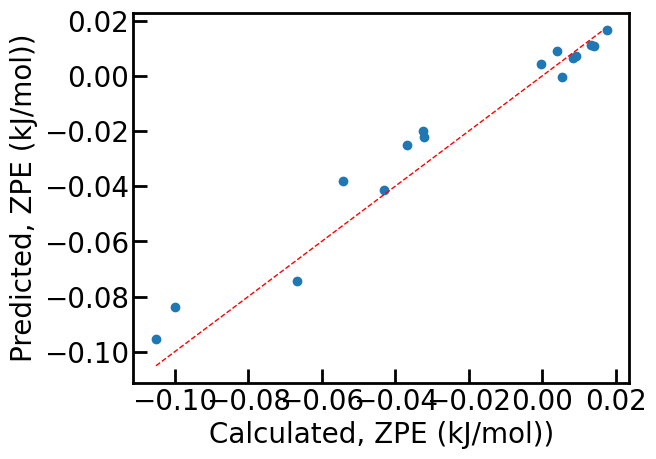

GB 0.9019574281448505
RMSE:  0.07932969191861397
RMSE unscaled:  0.012301205347886292
----------------------------------------


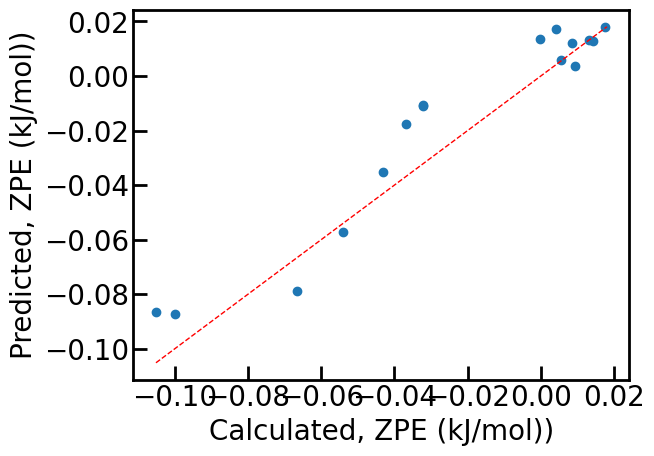

LR 0.9796209783531742
RMSE:  0.03616763285334741
RMSE unscaled:  0.005608309674672923
----------------------------------------


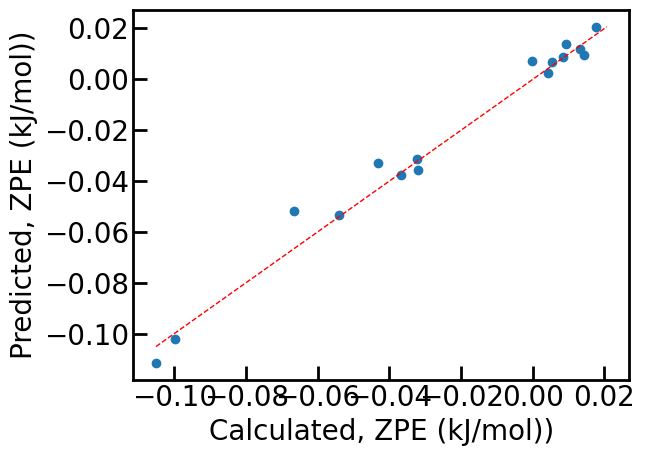

RR 0.9862001989845232
RMSE:  0.029762186390694983
RMSE unscaled:  0.00461505342501023
----------------------------------------


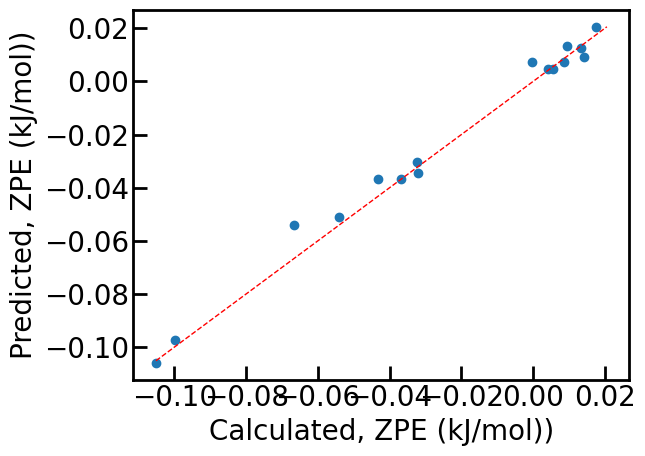

LASSO 0.8243018258047676
RMSE:  0.10619695010829436
RMSE unscaled:  0.016467358677524895
----------------------------------------


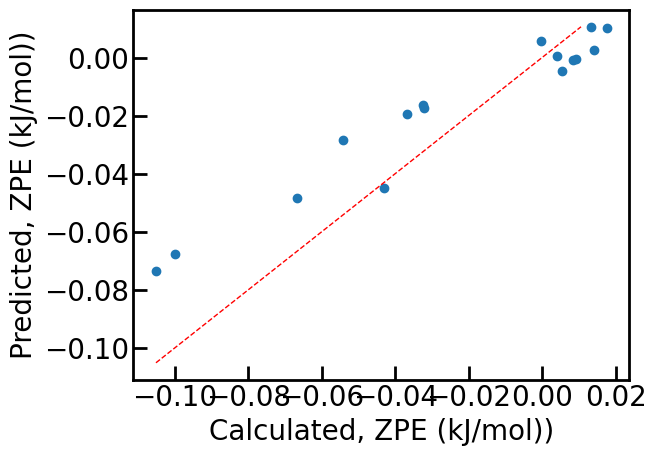

gpr1 0.9815738676906773
RMSE:  0.034391056113349895
RMSE unscaled:  0.0053328259967908975
----------------------------------------


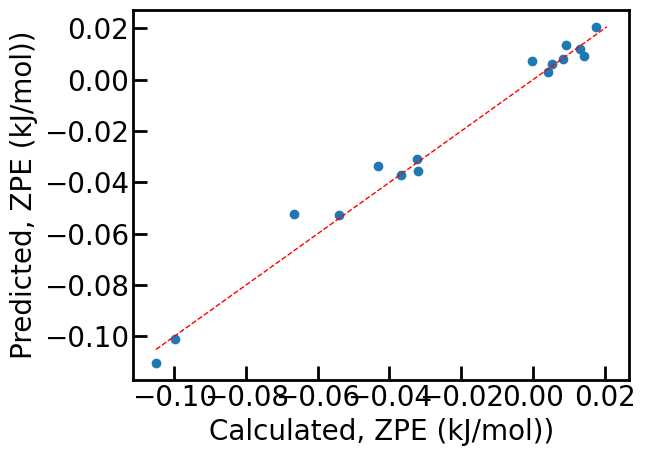

gpr2 0.9855002159409235
RMSE:  0.030507680350053447
RMSE unscaled:  0.004730652944659007
----------------------------------------


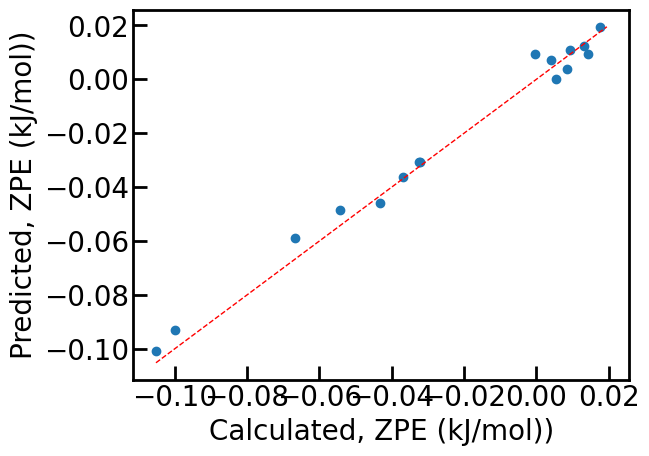

gpr3 0.99013910703167
RMSE:  0.025158604188198323
RMSE unscaled:  0.003901202045543338
----------------------------------------


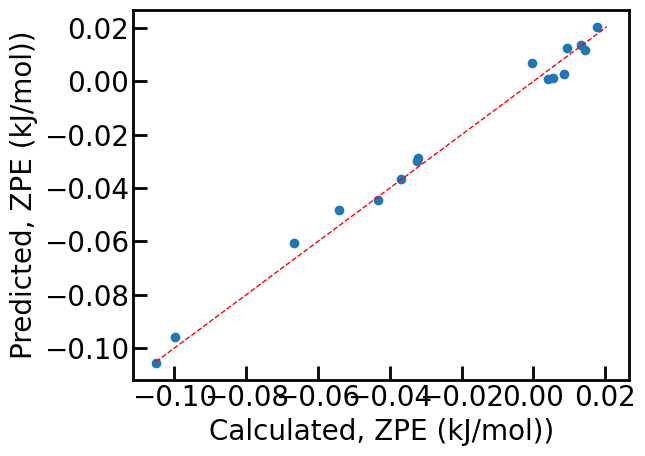

gpr4 0.9901391070292188
RMSE:  0.02515860419132521
RMSE unscaled:  0.003901202046028207
----------------------------------------


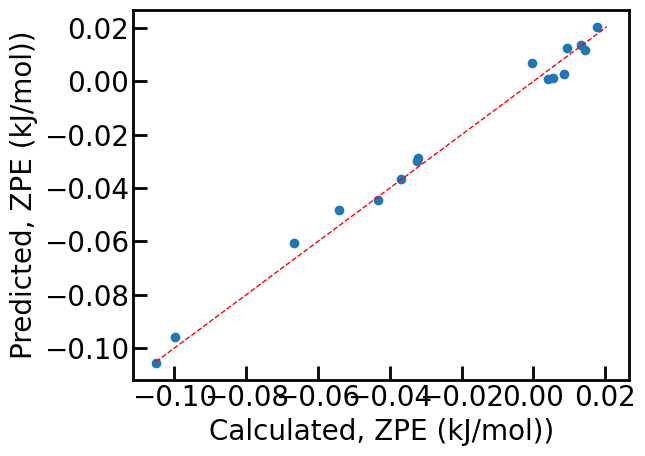

gpr5 0.9874185671686919
RMSE:  0.028417997505115814
RMSE unscaled:  0.004406617679100369
----------------------------------------


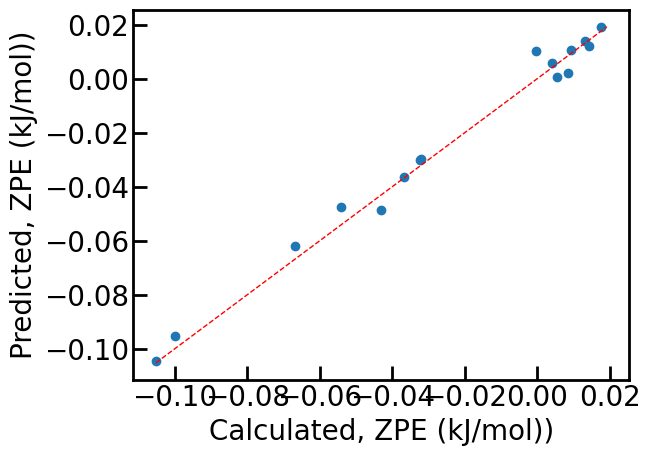

gpr6 0.9565123763802768
RMSE:  0.05283372827257205
RMSE unscaled:  0.00819262655705382
----------------------------------------


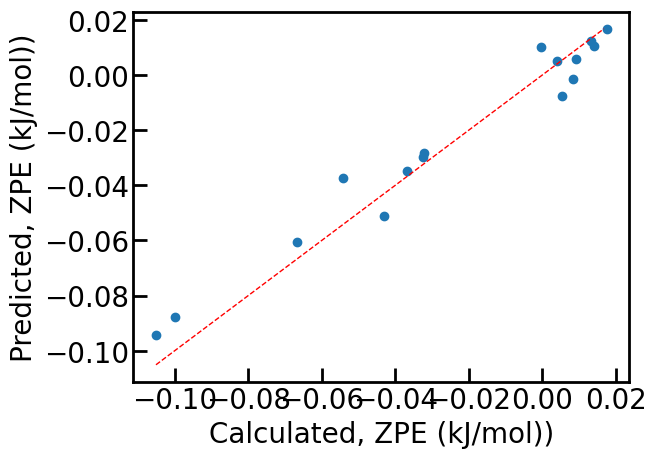

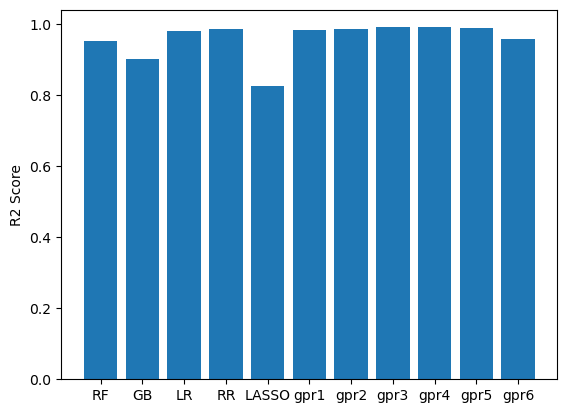

In [37]:
run_models()

In [38]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI', 'X_IEI', 'X_MV', 'std_A2X',
       'B_Kappa', 'B_EA', 'A_ChiA', 'A_Z', 'std_B2X', 'X_ChiP', 'A_ChiP'],
      dtype=object)

In [39]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9447870900688774
RMSE:  0.059531762223376465
RMSE unscaled:  0.009231252688874536
----------------------------------------


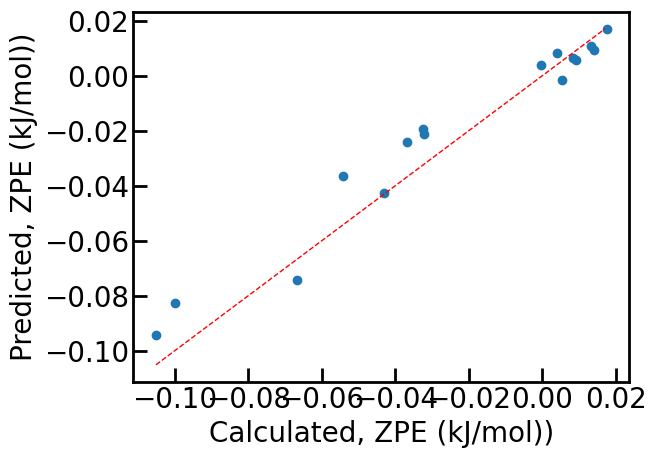

GB 0.9109384634129702
RMSE:  0.0756090031074704
RMSE unscaled:  0.011724259238623504
----------------------------------------


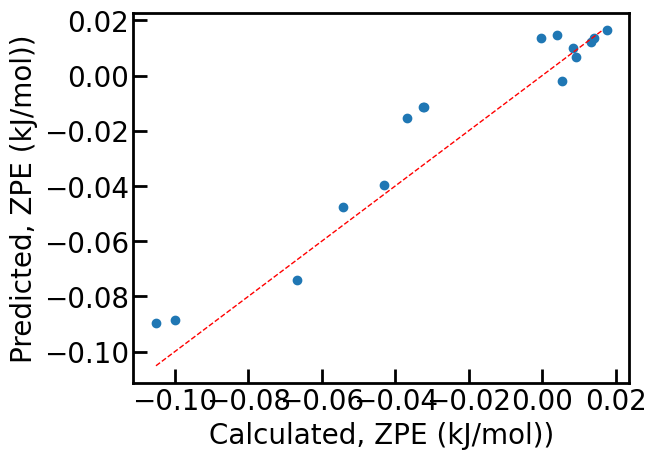

LR 0.9527526314361672
RMSE:  0.05507027343891421
RMSE unscaled:  0.008539434929752692
----------------------------------------


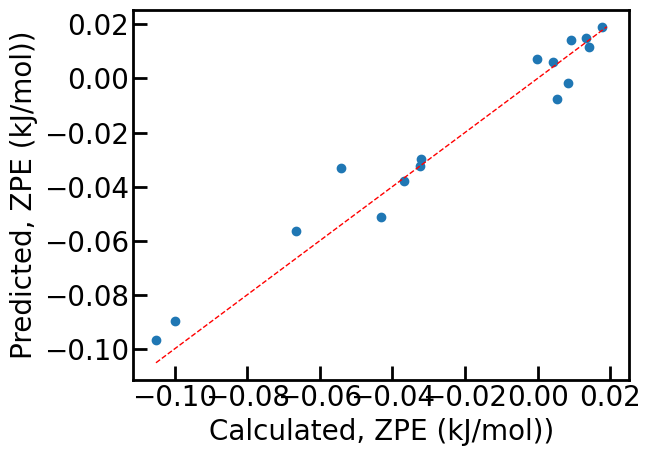

RR 0.9551869249278672
RMSE:  0.05363283982763553
RMSE unscaled:  0.008316540253136107
----------------------------------------


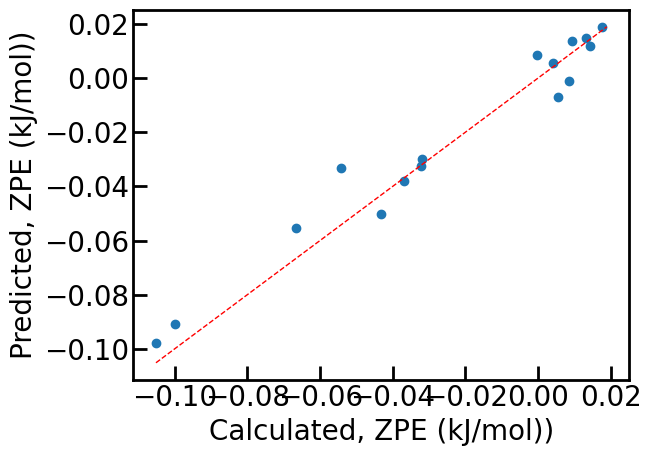

LASSO 0.8243018258047676
RMSE:  0.10619695010829436
RMSE unscaled:  0.016467358677524895
----------------------------------------


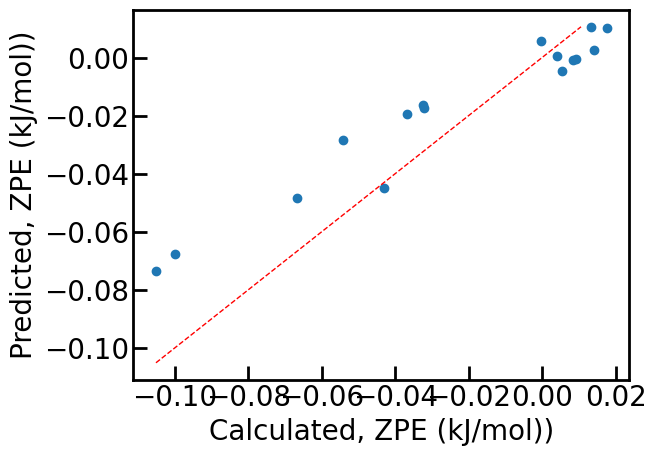

gpr1 0.9545077636306692
RMSE:  0.054037725841161566
RMSE unscaled:  0.008379323630638449
----------------------------------------


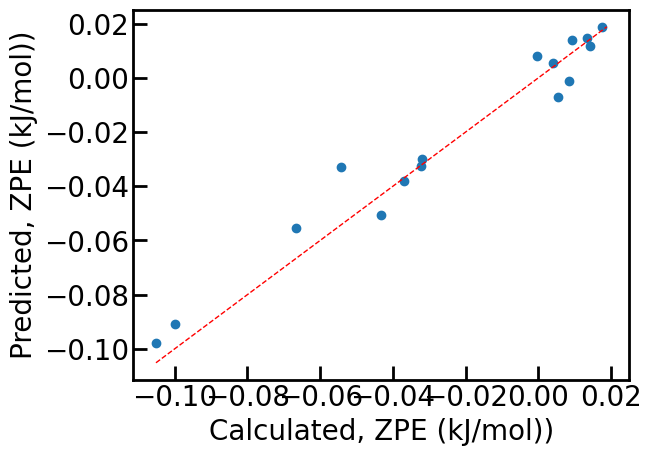

gpr2 0.9761592419176994
RMSE:  0.039119063607753954
RMSE unscaled:  0.006065971300502368
----------------------------------------


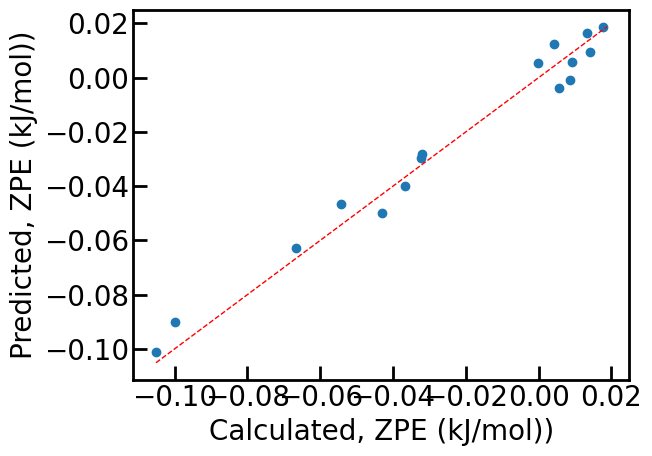

gpr3 0.9650736583018134
RMSE:  0.047348363096092326
RMSE unscaled:  0.007342042093505828
----------------------------------------


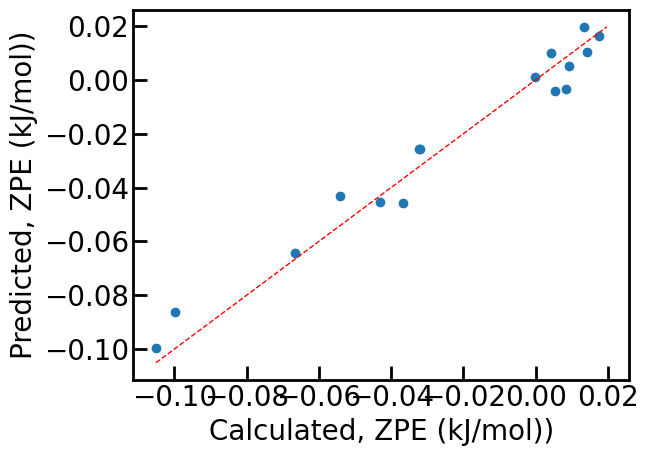

gpr4 0.9650736583740437
RMSE:  0.04734836304713231
RMSE unscaled:  0.007342042085913877
----------------------------------------


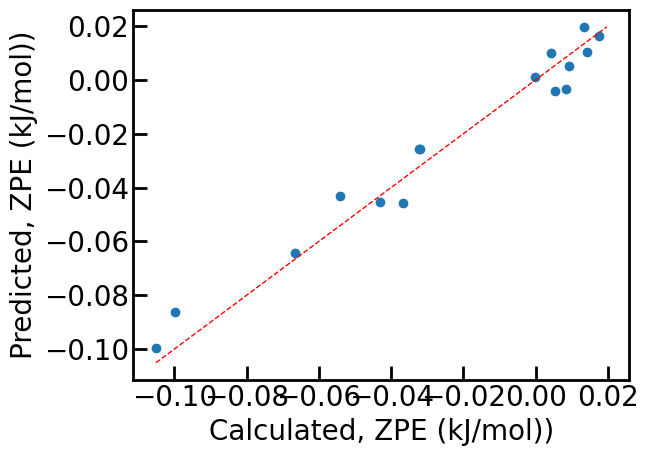

gpr5 0.9709277732988636
RMSE:  0.043198390733719665
RMSE unscaled:  0.006698529418958045
----------------------------------------


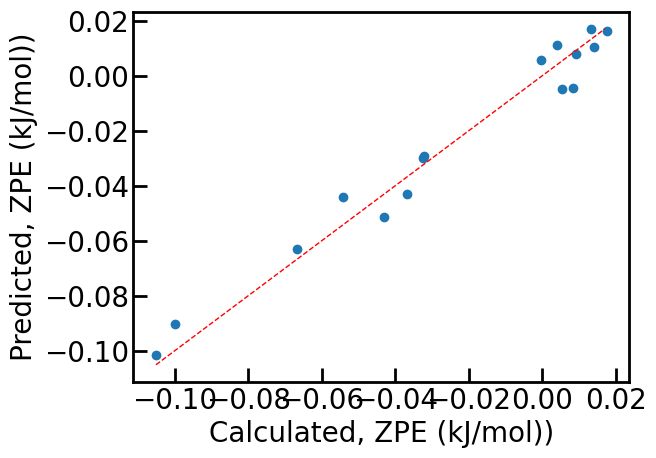

gpr6 0.9402531151014119
RMSE:  0.0619278572734477
RMSE unscaled:  0.009602801557036269
----------------------------------------


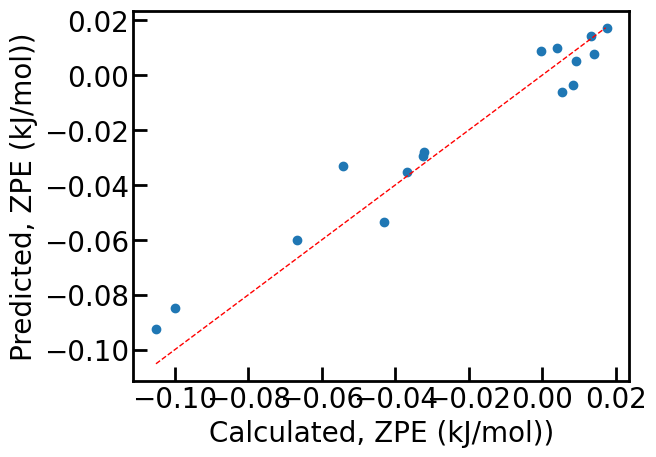

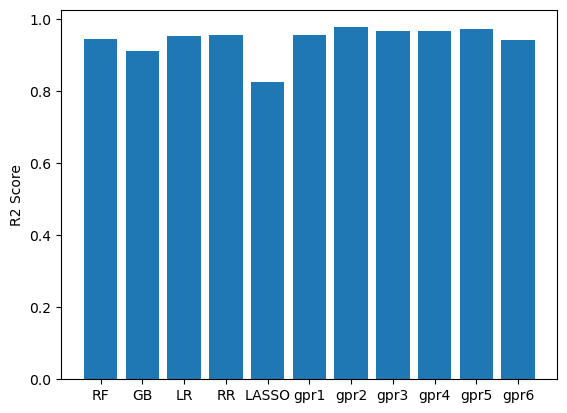

In [40]:
run_models()

In [41]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw', 'X_Kappa',
       'A_Rvdw', 'X_EA', 'E_coh', 'A_IEI'], dtype=object)

In [42]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9141863831779666
RMSE:  0.07421753457711201
RMSE unscaled:  0.011508492106379744
----------------------------------------


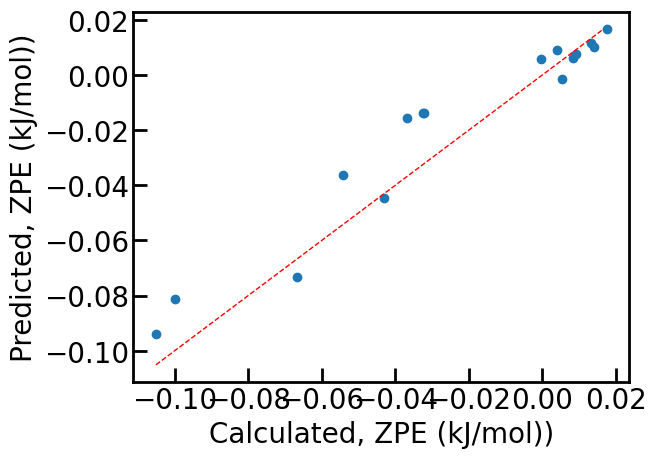

GB 0.7739125746032249
RMSE:  0.12046659197909067
RMSE unscaled:  0.018680071101437313
----------------------------------------


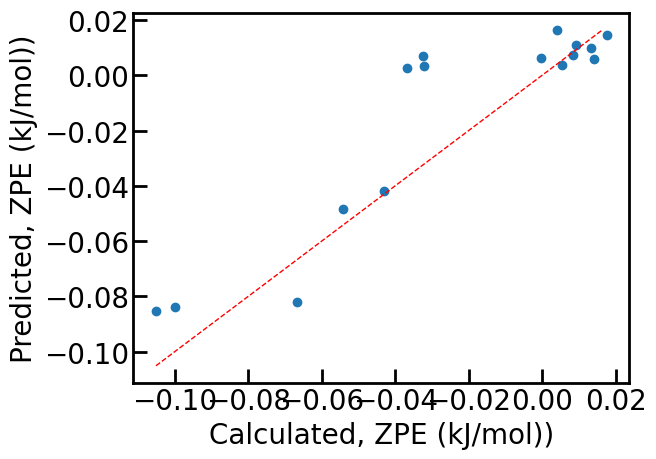

LR 0.8786264578861995
RMSE:  0.08826538772853314
RMSE unscaled:  0.013686813011619964
----------------------------------------


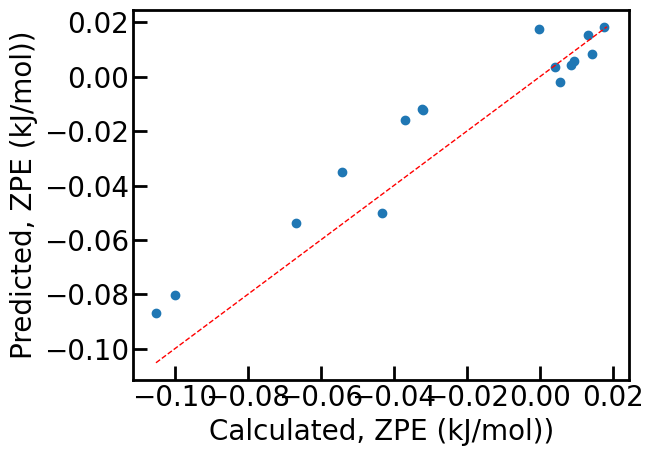

RR 0.8788715537979178
RMSE:  0.08817622324610762
RMSE unscaled:  0.013672986781093575
----------------------------------------


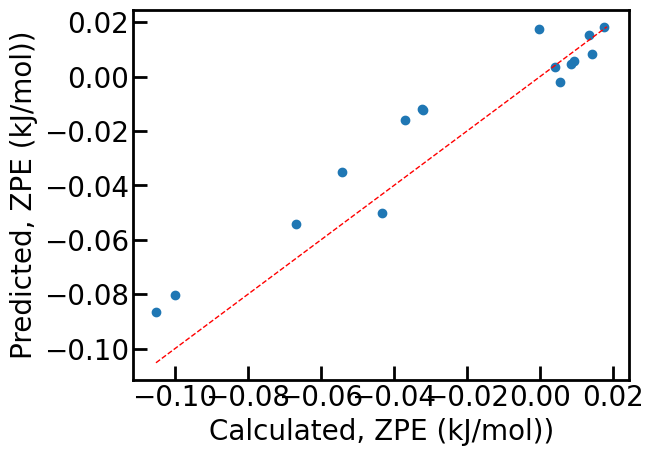

LASSO 0.8037482491974238
RMSE:  0.11223677779419995
RMSE unscaled:  0.017403920497358966
----------------------------------------


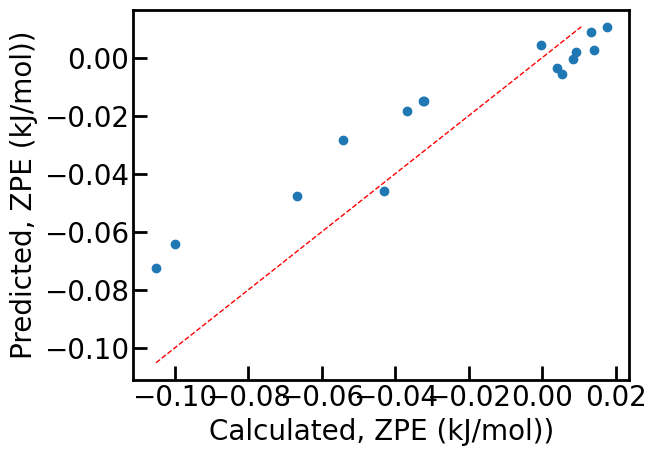

gpr1 0.8780215654416949
RMSE:  0.08848505961443294
RMSE unscaled:  0.013720876284932347
----------------------------------------


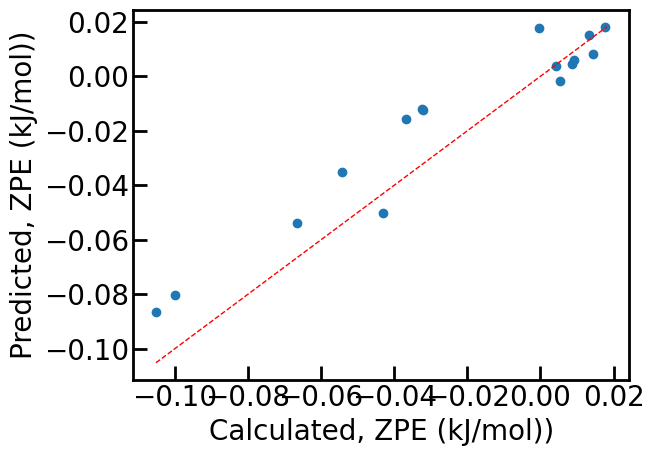

gpr2 0.8790929632500182
RMSE:  0.08809559817599244
RMSE unscaled:  0.013660484708796458
----------------------------------------


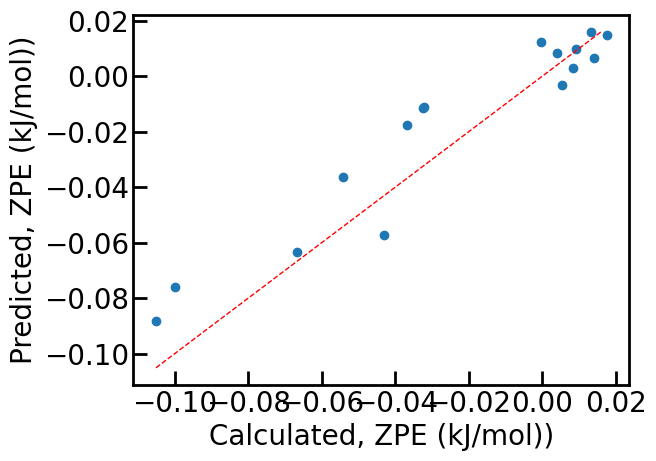

gpr3 0.7732331559625959
RMSE:  0.12064746415751376
RMSE unscaled:  0.01870811792419297
----------------------------------------


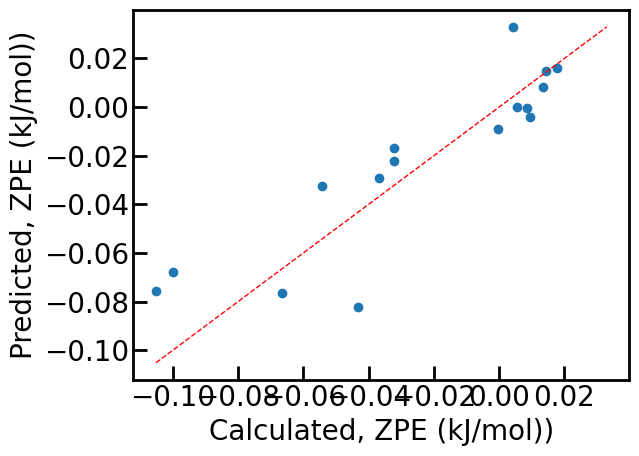

gpr4 0.7732331387957009
RMSE:  0.12064746872419176
RMSE unscaled:  0.01870811863232182
----------------------------------------


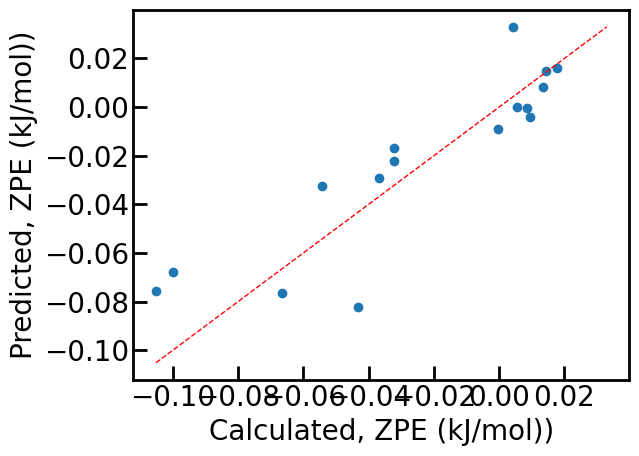

gpr5 0.8484948793041449
RMSE:  0.09861479493723281
RMSE unscaled:  0.015291636883036478
----------------------------------------


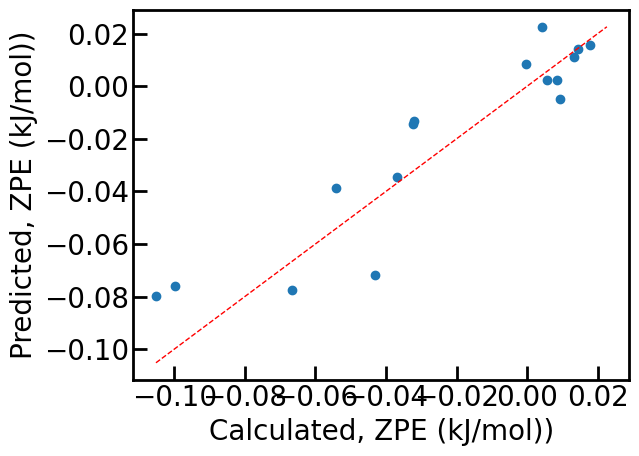

gpr6 0.880011101192808
RMSE:  0.08776047272617281
RMSE unscaled:  0.013608518706208632
----------------------------------------


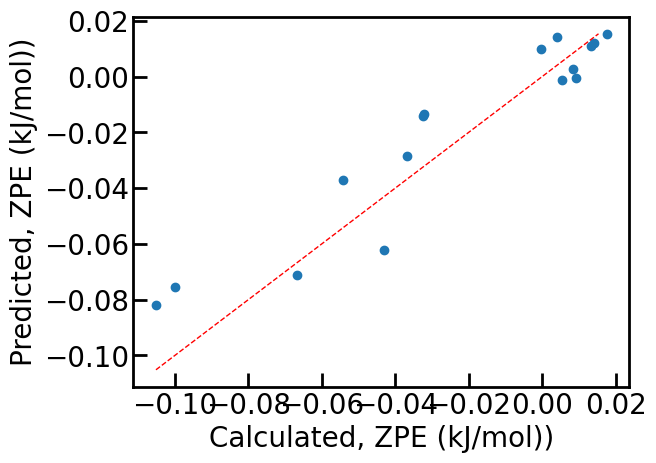

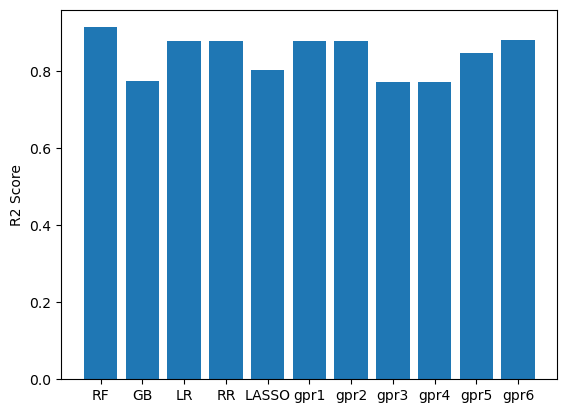

In [43]:
run_models()